In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim
import folium
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
from pandas.plotting import table

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 5.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.6.0 requires urllib3[socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.


In [ ]:
tehsil = pd.read_csv('/content/delhi_Locality.csv')
#tehsil.columns = ['Neighborhood', 'Borough', 'Population', 'Literacy', 'Sex Ratio', 'Postal Code'] #Neighborhood: Tehsil of Delhi, Borough: District of Delhi in which the Tehsil is situated, Postal Code: NIC Tehsil Code

In [ ]:
tehsil.rename(columns = {"place_name": "Neighborhood", "admin_name3": "Borough", "latitude": "Latitude", "longitude": "Longitude"}, inplace = True)

In [ ]:
tehsil.head()

,key,Neighborhood,Borough,Latitude,Longitude,accuracy
0,IN/110001,Connaught Place,New Delhi,28.6333,77.2167,4.0
1,IN/110002,Darya Ganj,New Delhi,28.6333,77.2500,4.0
2,IN/110003,Aliganj,New Delhi,28.6500,77.2167,NaN
3,IN/110004,Rashtrapati Bhawan,New Delhi,28.6500,77.2167,NaN
4,IN/110005,Lower Camp Anand Parbat,New Delhi,28.6500,77.2000,NaN


In [ ]:
query = '{}, Chanakyapuri, New Delhi'
g = geocoder.arcgis(query.format(2085))
g.latlng

[28.59505000000007, 77.18574000000007]

In [ ]:
latitude = 28.7041
longitude = 77.1025

# create map of Delhi using latitude and longitude values
map_on = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tehsil['Latitude'], tehsil['Longitude'], tehsil['Borough'], tehsil['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_on)  
    
map_on

In [ ]:
CLIENT_ID = 'SMW0KBR1QLGVOEBX3HFOQFVCABUB5HXWFTUZZCZMHFD5PVTW' 
CLIENT_SECRET = '3KAMZFVCZ15XQ04SVTKVDMVTEFQJASZNQRSVTUUNUZHX4PDZ'
VERSION = '20200406'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SMW0KBR1QLGVOEBX3HFOQFVCABUB5HXWFTUZZCZMHFD5PVTW
CLIENT_SECRET:3KAMZFVCZ15XQ04SVTKVDMVTEFQJASZNQRSVTUUNUZHX4PDZ


In [ ]:
neighborhood_latitude = tehsil.loc[1, 'Latitude'] # Tehsil latitude value
neighborhood_longitude = tehsil.loc[1, 'Longitude'] # Tehsil longitude value

neighborhood_name = tehsil.loc[1, 'Neighborhood']# Tehsil name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Darya Ganj are 28.6333, 77.25.


In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    1020, 
    100)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=SMW0KBR1QLGVOEBX3HFOQFVCABUB5HXWFTUZZCZMHFD5PVTW&client_secret=3KAMZFVCZ15XQ04SVTKVDMVTEFQJASZNQRSVTUUNUZHX4PDZ&v=20200406&ll=28.6333,77.25&radius=1020&limit=100'

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            1020, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
n_venues = getNearbyVenues(names=tehsil['Neighborhood'],latitudes=tehsil['Latitude'], longitudes=tehsil['Longitude'])

Connaught Place
Darya Ganj
Aliganj
Rashtrapati Bhawan
Lower Camp Anand Parbat
Bara Tooti
Birla Lines
Patel Nagar
Delhi Cantt
Nirman Bhawan
Inderpuri
Hazrat Nizamuddin
Jangpura
Zakhira
Hauz Khas
Vishnu Garden
Nehru Place
Flatted Factories Complex
Malcha Marg
Postal Saving Bureau
Kidwai Nagar
Lajpat Nagar
Jamia Nagar
Punjabi Bagh
J 6block Rajouri Garden
Naraina Industrial Estate
Himayunpur Extn
T B Hospital
Gandhi Nagar
Shahdara
Adarsh Nagar
Pitampura
Inderlok
Alipur
Gurgaon Road
A F Rajokari
Bawana
Sanoth
Nagloi
Badli
Najafgarh
Badarpur T P Station
Palam Enclave
Nangal Rava
Arjan Garh
Kailash
Andrews Ganj
Azad Nagar
Wazirpur Phase Iii
Zafrabad
Civil Lines
Paharganj
Shakurbasti
Munirka
Janakpuri
Uttam Nagar
New Rajinder Nagar
Bijwasan
Hamdard Nagar
Paschim Vihar
Hari Nagar Be Block
East Of Kailash
R K Puram
D D A Munirka
Vasant Kunj
Chhawla
Jharoda Kalan
Ujwa
Kanjhawala
Khera Kalan
Mangolpuri Block A
Kutubgarh
Shalimar Bagh
Himmatpuri
Shakarpur
Nand Nagri A Block
Gokulpuri


In [ ]:
frequency = pd.get_dummies(n_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
frequency['Neighborhood'] = n_venues['Neighborhood'] 
fixed_columns = [frequency.columns[-1]] + list(frequency.columns[:-1])
frequency = frequency[fixed_columns]

#frequency.head()

In [ ]:
frequency_grouped = frequency.groupby('Neighborhood').mean().reset_index()
#frequency_grouped
frequency_grouped.head()

,Neighborhood,ATM,Airport Terminal,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Stadium,Tea Room,Tibetan Restaurant,Track,Train Station,Udupi Restaurant
0,A F Rajokari,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
1,Adarsh Nagar,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
2,Aliganj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.00,0.0
3,Alipur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
4,Andrews Ganj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0


In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
def getTopLocations(f):  
  columns = ['Neighborhood', 'Common Venue', 'Advertisement']

  # create a new dataframe
  tehsil_venues_sorted = pd.DataFrame(columns=columns)
  tehsil_venues_sorted['Neighborhood'] = f['Neighborhood']

  for ind in range(f.shape[0]):
      #print(tehsil_venues_sorted.iloc[ind, 1:])
      #print(return_most_common_venues(f.iloc[ind, :], 1))
      tehsil_venues_sorted.iloc[ind, 1:] = return_most_common_venues(f.iloc[ind, :], 1)

  return tehsil_venues_sorted

In [ ]:
# def getTopLocations():
#   num_top_venues = 5

#   indicators = ['st', 'nd', 'rd']

#   columns = ['Neighborhood']
#   for ind in np.arange(num_top_venues):
#       try:
#           columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
#       except:
#           columns.append('{}th Most Common Venue'.format(ind+1))

#   # create a new dataframe
#   tvs = pd.DataFrame(columns=columns)
#   tvs['Neighborhood'] = frequency_grouped['Neighborhood']

#   for ind in np.arange(frequency_grouped.shape[0]):
#       tehsil_venues_sorted.iloc[ind, 1:] = return_most_common_venues(frequency_grouped.iloc[ind, :], num_top_venues)

#   return tvs

In [ ]:
def makeClusters(criteria):
  k_rng = range(1,10)
  sse = []
  # f = frequency[['Neighborhood', 'Bank', 'High School', 'Shopping Mall', 'Train Station']]
  for k in k_rng:
      km = KMeans(n_clusters=k)
      km.fit(criteria)
      # km.fit(frequency[['Bank', 'High School', 'Shopping Mall', 'Train Station']])
      #km.fit(f)
      sse.append(km.inertia_)
  
  plt.xlabel('k')
  plt.ylabel('Sum of Squared error')
  plt.plot(k_rng,sse)

  

In [ ]:
from re import X
def clustering(tvs, size, ad_class):
  kclusters = size
  tehsil_grouped_clustering = tvs.drop('Neighborhood', 1)

  x = tehsil_grouped_clustering[['Common Venue']]
  target = tehsil_grouped_clustering[['Advertisement']]

  kmeans = KMeans(n_clusters=kclusters).fit(x)
  kmeans.labels_[0:10]
  #print(kmeans.predict([[1]]))

  tvs.insert(0, 'Cluster Labels', kmeans.labels_)
  tehsil_merged = tehsil
  tehsil_merged = tehsil_merged.join(tehsil_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

  temp = tehsil_merged
  temp = temp[temp['Cluster Labels'].notna()]

  map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
  # set color scheme for the clusters
  x = np.arange(kclusters)
  ys = [i + x + (i*x)**2 for i in range(kclusters)]
  colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
  rainbow = [colors.rgb2hex(i) for i in colors_array]

  # add markers to the map
  markers_colors = []
  areas = []
  for lat, lon, poi, cluster in zip(temp['Latitude'], temp['Longitude'], temp['Neighborhood'], temp['Cluster Labels']):
      #if cluster != undefined:
      cluster = int(cluster)
      cluster1 = tehsil_merged.loc[tehsil_merged['Cluster Labels'] == cluster, tehsil_merged.columns[[1] + list(range(5, tehsil_merged.shape[1]))]]
      #print(cluster)
      if ad_class not in cluster1['Advertisement'].values:
        continue
      areas.append(cluster1['Neighborhood'].tolist())
      label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
      folium.CircleMarker(
          [lat, lon],
          radius=25,
          popup=label,
          color=rainbow[cluster-1],
          fill=True,
          fill_color=rainbow[cluster-1],
          fill_opacity=0.7).add_to(map_clusters)

  #areas = set(areas)
  #cls = set(cls)
  a_list = []
  for area in areas:
    for a in area:
      a_list.append(a)
  print(set(a_list))

  return map_clusters

{'Shop & Service', 'Fast Food Restaurant', 'Cosmetics Shop', 'ATM', 'Indian Restaurant', 'Udupi Restaurant', 'Train Station', 'Playground', 'Hotel', 'Airport Terminal', 'Farm', 'Pizza Place'}


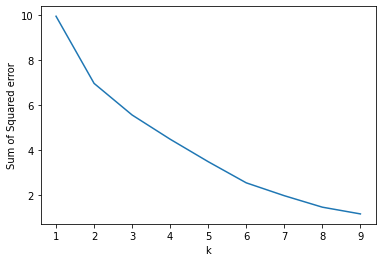

In [ ]:
f = frequency_grouped
#print(f.loc[:, f.columns != 'Neighborhood'])
#print(type(f))
tehsil_venues_sorted = getTopLocations(f)
print(set(tehsil_venues_sorted['Common Venue'].tolist()))

tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Train Station', 'Advertisement'] = 'Automobile'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Airport Terminal', 'Advertisement'] = 'Automobile'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Hotel', 'Advertisement'] = 'Automobile'

tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Indian Restaurant', 'Advertisement'] = 'F & B'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Udupi Restaurant', 'Advertisement'] = 'F & B'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Farm', 'Advertisement'] = 'F & B'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Fast Food Restaurant', 'Advertisement'] = 'F & B'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Pizza Place', 'Advertisement'] = 'F & B'



 #or tehsil_venues_sorted['Common Venue'] == 'Fast Food Restaurant' or tehsil_venues_sorted['Common Venue'] == 'Udupi Restaurant' or tehsil_venues_sorted['Common Venue'] == 'Farm' or tehsil_venues_sorted['Common Venue'] == 'Pizza Place'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'ATM', 'Advertisement'] = 'Electronics'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Shop & Service', 'Advertisement'] = 'Electronics'

tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Cosmetics Shop', 'Advertisement'] = 'Media'
tehsil_venues_sorted.loc[tehsil_venues_sorted['Common Venue'] == 'Playground', 'Advertisement'] = 'Media'

tehsil_venues_sorted.head(50)
makeClusters(f.loc[:, f.columns != 'Neighborhood'])

In [ ]:
from sklearn import preprocessing

In [ ]:
import io
from PIL import Image
import selenium

In [ ]:
le = preprocessing.LabelEncoder()
temp = tehsil_venues_sorted
target = temp['Common Venue']
le.fit(target.tolist())
tvs = le.transform(target)
temp['Common Venue'] = pd.Series(tvs)

target = temp['Advertisement']
le.fit(target.tolist())
tvs = le.transform(target)
temp['Advertisement'] = pd.Series(tvs)
#print(temp)

map = clustering(temp, 9, 1)
map

{'Inderlok', 'Gandhi Nagar', 'Bawana', 'Adarsh Nagar', 'A F Rajokari', 'Palam Enclave', 'T B Hospital', 'Gurgaon Road', 'Pitampura', 'Shahdara'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
